#Segunda ronda de experimentos

Recargamos los datos y los transformamos para la nueva representación que usaremos.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt

In [4]:
# train_dataloader = torch.load('/content/drive/MyDrive/256TrainDataloader.pth')
# test_dataloader = torch.load('/content/drive/MyDrive/256TestDataloader.pth')

In [5]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [6]:
x, y = np.load('/content/drive/MyDrive/x.npy'), np.load('/content/drive/MyDrive/y.npy')
ids_1, ids_2 = np.unique(y, return_inverse=True)
y = to_categorical(ids_2, 10)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size = 0.2,random_state=777,shuffle=True)
print('train_X:', X_train.shape)
print('train_y:', y_train.shape)
print('test_X:', X_test.shape)
print('test_y:', y_test.shape)

train_X: (2400, 256, 256)
train_y: (2400, 10)
test_X: (600, 256, 256)
test_y: (600, 10)


In [13]:
#pasando a tensores
tensor_x_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_x_train = torch.unsqueeze(tensor_x_train, 1)
print("tensor_x_train.shape: ", tensor_x_train.shape)
print("tensor_y_train.shape: ", tensor_y_train.shape)

train_set = data.TensorDataset(tensor_x_train,tensor_y_train)
train_dataloader = data.DataLoader(train_set,batch_size=32, shuffle=True)

# Creating a dataloader for test data
tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test)
tensor_x_test = torch.unsqueeze(tensor_x_test, 1)
print("tensor_x_test.shape: ", tensor_x_test.shape)
print("tensor_y_test.shape: ", tensor_y_test.shape)
test_set = data.TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = data.DataLoader(test_set, batch_size=32, shuffle=False)

tensor_x_train.shape:  torch.Size([2400, 1, 256, 256])
tensor_y_train.shape:  torch.Size([2400, 10])
tensor_x_test.shape:  torch.Size([600, 1, 256, 256])
tensor_y_test.shape:  torch.Size([600, 10])


##Modelo de Conv1d y LTSM

Aquí se llevó a cabo un proseso muy largo de experimentación y prueba-error. Incluso con la representación escogida de audio en MFCC complicaba el espacio de hipótesis, y varias arquitecturas convolucionales de 2 dimensiones fallaban en encontrar una representación significante de los datos, estancandose con toda combinación de optimizadores y learning-rates en un Accuracy de 30.

Por este motivo se experimentó la representación en convoluciones unidimensionales ya que los MFCC's se basan en ventanas cortas de tiempo tomadas secuencialmente, por lo que podemos entender que la representación del audi es comprendida en vectores unidimensionales.

Para ingresarlo primero transformaremos la imagen a un arreglo continuo/secuencial en lugar de trabajarlo como una imagen bidimensional. Como esto representa una serie de tiempo de imágenes hace sentido utilizar una LSTM para tratar de predecir como ocurren estos.

Bengio y Xavier recomiedan para convoluciones usar una [xavier uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

También consulté de referencia este link:
*   https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79

Los primeros resultados con una convolución2d presentaba muchos problemas con la velocidad a la que mejoraba, por lo que decidí utilizarlas en este segundo experimento.


In [34]:
class CRNN(nn.Module):
  def __init__(self):
    super(CRNN, self).__init__()
    
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.bn1 = nn.BatchNorm1d(32)
    self.drop1  = nn.Dropout(0.5)

    self.conv2 = nn.Conv1d(in_channels=32, out_channels=40, kernel_size=5)
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.bn2 = nn.BatchNorm1d(40)
    self.drop2  = nn.Dropout(0.5)

    self.conv3 = nn.Conv1d(in_channels=40, out_channels=52, kernel_size=5)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.bn3 = nn.BatchNorm1d(52)
    self.drop3  = nn.Dropout(0.5)

    self.rnn = nn.LSTM(10236, 96, 1)
    self.drop4  = nn.Dropout(0.5)

    self.fc1    = nn.Linear(in_features=4992, out_features=64)
    self.drop5  = nn.Dropout(0.5)
    self.fc2    = nn.Linear(in_features=64,  out_features=8)

  def forward(self, x):
    #aplanamos las imagenes
    x = x.view(-1,1, self.flat_images(x))

    x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
    x   = self.drop1(x)
    x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
    x   = self.drop2(x)
    x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
    x   = self.drop3(x)

    x, (hn,cn) = self.rnn(x)
    x = self.drop4(x)

    x = x.view(-1,self.flat_images(x))
    x = self.fc1(x)
    x   = self.drop5(x)
    x = self.fc2(x)
    return x

  def flat_images(self, x):
      size = x.size()[1:] 
      num_features = 1
      for s in size:
          num_features *= s
      return num_features
    
  def train(self,epochs,data_loader,criterion,optimizer,cuda=False): 
    error = np.zeros(epochs)
#         since = time.time()
    best_acc = 0.0
    device = torch.device("cuda:0") if (cuda == True) else torch.device("cpu:0")
    optimizer.zero_grad()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('----------')
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds== torch.argmax(labels.data))
        epoch_loss = running_loss / len(data_loader)
        epoch_acc = running_corrects.double() / len(data_loader)
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        error[epoch] = epoch_loss
        if(epoch_acc > best_acc):
            best_acc = epoch_acc
            print('----------')
#         time_elapsed = time.time() - since
#         print('Entrenamiento completado {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    steps = np.arange(epochs)
    plt.plot(steps, error, label='Error entrenamiento')
    plt.legend()
    plt.title('Error')
        

Epoch 0/499
----------
Loss: 9.9930 Acc: 3.1600
----------
Epoch 1/499
----------
Loss: 9.2362 Acc: 3.6400
----------
Epoch 2/499
----------
Loss: 8.7102 Acc: 3.1733
Epoch 3/499
----------
Loss: 8.3531 Acc: 3.2933
Epoch 4/499
----------
Loss: 7.9608 Acc: 3.1733
Epoch 5/499
----------
Loss: 7.8323 Acc: 3.2533
Epoch 6/499
----------
Loss: 7.5303 Acc: 3.4000
Epoch 7/499
----------
Loss: 7.4271 Acc: 3.1600
Epoch 8/499
----------
Loss: 7.1618 Acc: 3.5467
Epoch 9/499
----------
Loss: 6.9144 Acc: 3.3467
Epoch 10/499
----------
Loss: 6.7439 Acc: 3.8000
----------
Epoch 11/499
----------
Loss: 6.5587 Acc: 3.3867
Epoch 12/499
----------
Loss: 6.4154 Acc: 3.4000
Epoch 13/499
----------
Loss: 6.2839 Acc: 3.5600
Epoch 14/499
----------
Loss: 6.0383 Acc: 3.1467
Epoch 15/499
----------
Loss: 5.9554 Acc: 3.4000
Epoch 16/499
----------
Loss: 5.7699 Acc: 4.0000
----------
Epoch 17/499
----------
Loss: 5.5984 Acc: 3.6533
Epoch 18/499
----------
Loss: 5.5149 Acc: 3.5467
Epoch 19/499
----------
Loss: 5.293

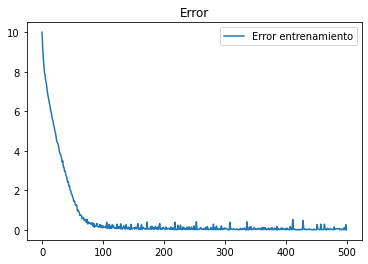

In [35]:
music_net=CNN()
#Define el criterio que usaras para evaluar a la red y un optimizador.
#Y define el preprosesamiento necesario en caso de requerir usar cuda.

# optimizer = torch.optim.SGD(music_net.parameters(), lr= 0.01, momentum=0.5)
# optimizer = torch.optim.Adam(music_net.parameters(),weight_decay=0.01)
optimizer = torch.optim.RMSprop(music_net.parameters(), lr=1e-5)
# criterio = nn.CrossEntropyLoss()
criterio = nn.BCELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
music_net = music_net.to(device)


#Entrenamos la red durante 500 pasos
music_net.train(500,train_dataloader,criterio,optimizer,cuda=True) 

#Resultados

In [36]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==torch.argmax(labels)).sum()
    return cantidadCorrectas

def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

In [39]:
prec_train =calcularPrecisionGlobal(music_net,train_dataloader,10,cuda=True)
prec_val   =calcularPrecisionGlobal(music_net,test_dataloader,10,cuda=True)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 43.4667%
Precision en conjunto de validacion: 34.2105%
